# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-l`
  - Task 5: Evaluating our Retriever



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

#####❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

---

**ANSWER:**

We are specifically relating *the questions* to *the documents*. This means that we are making our embedding model at the very specific task of relating potential questions to specific documents.

There are many caveats, but the main ones are:

- Your Q's should reflect the Q's of your users
- This kind of fine-tuning will (purposefully) "overfit" on your data; this is the desired result in this case.

## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [17]:
import nest_asyncio

nest_asyncio.apply()

In [14]:
#!pip install -qU langchain_openai langchain_huggingface langchain_core langchain langchain_community langchain-text-splitters

In [15]:
#!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml 

### Provide OpenAI API Key

In [13]:
from dotenv import load_dotenv

load_dotenv()

True

## Task 2: Loading Data

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [17]:
!mkdir data

mkdir: data: File exists


In [18]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31440    0 31440    0     0   149k      0 --:--:-- --:--:-- --:--:--  149k


In [19]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70299    0 70299    0     0   525k      0 --:--:-- --:--:-- --:--:--  528k


In [6]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader

path = "data/"
text_loader = DirectoryLoader(path, glob="*.html", loader_cls=BSHTMLLoader)

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

>> NOTE: You may need to run this cell twice to get it to work.

In [22]:
training_documents = text_splitter.split_documents(text_loader.load())

In [23]:
len(training_documents)

102

Next, we're going to associate each of our chunks with a unique identifier.

In [24]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [25]:
documents_total = len(training_documents)
training_split_documents = training_documents[:documents_total - 24]  # the biggest chunk for training
validation_split_documents = training_documents[documents_total - 24:documents_total-12]  # small chunks by 12 elems for test and validation
test_split_documents = training_documents[documents_total - 12:]

In [26]:
len(training_split_documents), len(validation_split_documents), len(test_split_documents)

(78, 12, 12)

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4o-mini` (released [today](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)).

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [11]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [28]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following JSON format:
{{
"questions": ["QUESTION #1", "QUESTION #2", ...]
}}

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [29]:
from langchain_core.output_parsers import JsonOutputParser

question_generation_chain = qa_prompt_template | qa_chat_model | JsonOutputParser()

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [30]:
from tqdm.asyncio import tqdm
from langchain_core.documents import Document
import uuid


async def create_questions(documents: list[Document], n_questions: int = 3) -> tuple[dict]:
  questions = {}
  relevant_docs = {}

  for doc in tqdm(documents, total=len(documents), desc="Processing docs"):
      llm_response = await question_generation_chain.ainvoke({"context": doc.page_content, "n_questions": n_questions})
      for q in llm_response["questions"]:
          q_id = str(uuid.uuid4())
          questions[q_id] = q
          relevant_docs[q_id] = [doc.metadata["id"]]

  return questions, relevant_docs

### REMOVE `await` IF NOT USING ASYNC (HINT: Use `async`)

In [31]:
training_questions, training_relevant_contexts = await create_questions(training_split_documents, 2)

Processing docs:  53%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 41/78 [00:55<00:49,  1.35s/it]


CancelledError: 

We'll use the function to generate training, validation, and test data.

In [27]:
val_questions, val_relevant_contexts = await create_questions(validation_split_documents, 2)

Processing docs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:21<00:00,  1.77s/it]


In [28]:
test_questions, test_relevant_contexts = await create_questions(test_split_documents, 2)

Processing docs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.28s/it]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [36]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [38]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in validation_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [39]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-l`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-l`](https://huggingface.co/Snowflake/snowflake-arctic-embed-l) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

>> NOTE: Skip installing dependencies if you are running this notebook locally.

In [40]:
#!pip install -qU sentence_transformers datasets pyarrow

In [41]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-l"
model = SentenceTransformer(model_id)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/85.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [42]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [43]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [44]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [45]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [47]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [48]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [49]:
EPOCHS = 10

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [50]:
import wandb
wandb.init(mode="disabled")

In [ ]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss


In [46]:
from huggingface_hub import notebook_login

notebook_login()

In [47]:
hf_username = "llm-wizard"

In [49]:
model.push_to_hub(f"{hf_username}/legal-ft-2")

model.safetensors: 100%|██████████| 1.34G/1.34G [00:35<00:00, 38.0MB/s]


'https://huggingface.co/llm-wizard/legal-ft-2/commit/fa3bc1d917e6c0beef1e06b3d31c4abd0899b25b'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [10]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [7]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [11]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

Failed to multipart ingest runs: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=ffb182b5-f82d-4f1a-93d3-e2a41f73de72,id=ffb182b5-f82d-4f1a-93d3-e2a41f73de72
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')
Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: T

In [12]:
te3_results_df = pd.DataFrame(te3_results)

In [13]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

np.float64(0.9)

### `Snowflake/snowflake-arctic-embed-l` (base)

In [14]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-l")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.55it/s]


In [15]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [16]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.7)

### `Snowflake/snowflake-arctic-embed-l` (fine-tuned)

In [2]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="llm-wizard/legal-ft-2")
# finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at llm-wizard/legal-ft-2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
finetune_results_df = pd.DataFrame(finetune_results)

In [61]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(1.0)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [7]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [8]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [9]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [14]:
rag_llm =  ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [15]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [18]:
base_rag_chain.invoke({"question" : "What is an agent?"})["response"]

'An agent, in the context of AI, is an infuriatingly vague term that generally refers to AI systems that can act on your behalf. There are two main interpretations: one sees agents as entities that go and perform tasks for you (like a travel agent), while the other views them as LLMs (large language models) that have access to tools and can run processes in a loop to solve problems. However, the term lacks a clear and widely understood definition, leading to confusion about its meaning and utility.'

In [19]:
base_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Organizations that have produced better-than-GPT-3 class models include Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, Baidu, and several others.'

In [20]:
base_rag_chain.invoke({"question" : "What is the laziest AI month?"})["response"]

'I do not know.'

In [21]:
base_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'I do not know.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [22]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [23]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [47]:
finetune_rag_chain.invoke({"question" : "What is an Agent?"})["response"]

'An "agent" is a term that lacks a single, clear, and widely understood meaning in the context of AI. It generally refers to AI systems that can act on behalf of a user, but there are various interpretations of what this entails. Some people view agents as systems that go and act on your behalf, similar to a travel agent, while others think of them as LLMs (Large Language Models) that have access to tools and can run tasks in a loop to solve problems. The term is often associated with concepts of autonomy, but there is significant ambiguity and skepticism surrounding their utility, particularly due to issues like gullibility, where AI systems may believe and act on false information.'

In [48]:
finetune_rag_chain.invoke({"question" : "Who has produced better models than GPT-3?"})["response"]

'Organizations that have produced better-than-GPT-3 class models include Anthropic, Mistral, Google, Meta, EleutherAI, Stability AI, TII in Abu Dhabi (Falcon), Microsoft Research, xAI, Replit, Baidu, and several others.'

In [49]:
finetune_rag_chain.invoke({"question" : "What is the laziest AI month?"})["response"]

'The laziest AI month is suggested to be December, as the context mentions that ChatGPT may get lazy in December due to its hidden system prompt including the current date and the observation that people provide less useful answers as the holidays approach.'

In [50]:
finetune_rag_chain.invoke({"question" : "What is the largest model that Simon has run on his phone?"})["response"]

'Simon has run the Mistral 7B model on his iPhone.'

####❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [24]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import BSHTMLLoader
from dotenv import load_dotenv

load_dotenv()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)
text_loader = DirectoryLoader("data/", glob="*.html", loader_cls=BSHTMLLoader)

docs_as_chunks = text_splitter.split_documents(text_loader.load())

In [25]:
len(docs_as_chunks)

102

In [26]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from ragas.testset import TestsetGenerator


generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs_as_chunks, testset_size=20)

Applying SummaryExtractor:   0%|          | 0/87 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/102 [00:00<?, ?it/s]

Node e07d4965-5af7-45bb-9e0c-2c051bce2afe does not have a summary. Skipping filtering.
Node 5810a9b7-87e3-4884-bde7-24c32dbbc80c does not have a summary. Skipping filtering.
Node 07069017-8302-4c8c-81e8-cf7bdc23a79f does not have a summary. Skipping filtering.
Node cdbd1cf5-47c0-489b-8b69-d9890196d7c2 does not have a summary. Skipping filtering.
Node 94036fe2-5eb2-4b1d-a9e3-ff5c62d98279 does not have a summary. Skipping filtering.
Node 8f67a02f-648f-499a-99f4-ca0f809dd07d does not have a summary. Skipping filtering.
Node 8c8b80bc-12bb-482a-9ec9-178bc76465c0 does not have a summary. Skipping filtering.
Node 6ddadbd4-66c0-49e4-8240-1c67b21a3663 does not have a summary. Skipping filtering.
Node ed802596-ba5f-4665-a5cb-174f377bf233 does not have a summary. Skipping filtering.
Node edd8fbcc-cdf7-46de-a45f-3b76ebe7e7a8 does not have a summary. Skipping filtering.
Node ab2acd5a-ad5c-4a6c-8dd5-188eba5f2572 does not have a summary. Skipping filtering.
Node c0028115-ebd6-4dfc-8123-ed3d4ffab5f4 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/291 [00:00<?, ?it/s]

unable to apply transformation: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-6PX9ZovnaTEDbiXm0A2pvlFW on tokens per min (TPM): Limit 30000, Used 29870, Requested 475. Please try again in 690ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
# Generate testset that contains: 
# - question
# - ragas context
# - ragas response
# - actual context
# - actual response 
# for base model (no fine tuning)

from copy import deepcopy

base_model_dataset = deepcopy(dataset)

for test_row in base_model_dataset:
  response = await base_rag_chain.ainvoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [28]:
# Generate testset that contains: 
# - question
# - ragas context
# - ragas response
# - actual context
# - actual response 
# for fine tuned model

from copy import deepcopy

finetune_model_dataset = deepcopy(dataset)

for test_row in finetune_model_dataset:
  response = await finetune_rag_chain.ainvoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [29]:
from ragas import EvaluationDataset
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

base_eval_dataset = EvaluationDataset.from_pandas(base_model_dataset.to_pandas())
finetune_eval_dataset = EvaluationDataset.from_pandas(finetune_model_dataset.to_pandas())

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
custom_run_config = RunConfig(timeout=360)

base_result = evaluate(
    dataset=base_eval_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)

finetune_result = evaluate(
    dataset=finetune_eval_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/120 [00:00<?, ?it/s]

In [32]:
import matplotlib.pyplot as plt
import numpy as np


def compare(x, y, x_name, y_name) -> None:
    dict1 = {k: round(v, 4) for k, v in x._repr_dict.items()}
    dict2 = {k: round(v, 4) for k, v in y._repr_dict.items()}

    assert dict1.keys() == dict2.keys()

    metrics = list(dict1.keys())
    values1 = list(dict1.values())
    values2 = list(dict2.values())

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width / 2, values1, width, label=x_name, color="blue", alpha=0.7)
    ax.bar(x + width / 2, values2, width, label=y_name, color="orange", alpha=0.7)

    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    ax.set_title("Comparison of Models")
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.ylim(0, 1)
    plt.show()

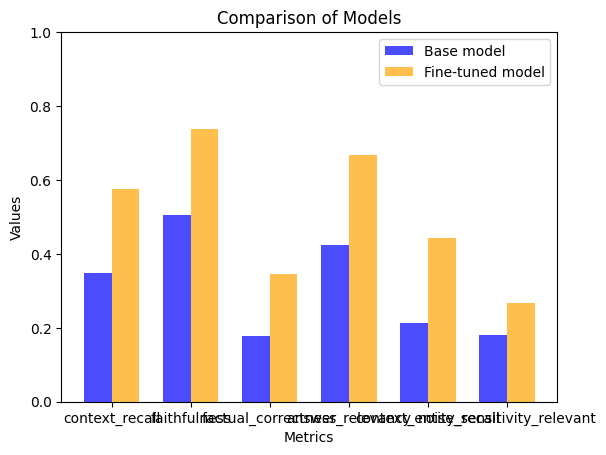

In [33]:
compare(base_result, finetune_result, "Base model", "Fine-tuned model")